In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [2]:
!pip install pmdarima
!pip install prophet
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.4 MB/s eta 0:00:0000:01


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electric-power-consumption-data-set


In [4]:
# Construct full path to the text file
data_file = os.path.join(path, "household_power_consumption.txt")

# Load the data
df = pd.read_csv(
    data_file,
    sep=';',                     # because it's semicolon-separated
    parse_dates=[[0, 1]],        # combine Date and Time columns
    infer_datetime_format=True,
    low_memory=False,
    na_values='?'
)
# Rename the combined column
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)

# Show first few rows
df.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.shape

(2075259, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Datetime,2075259,2008-12-06 07:13:00,2006-12-16 17:24:00,2007-12-12 00:18:30,2008-12-06 07:13:00,2009-12-01 14:07:30,2010-11-26 21:02:00,NaN
Global_active_power,2049280.0,1.091615,0.076,0.308,0.602,1.528,11.122,1.057294
Global_reactive_power,2049280.0,0.123714,0.0,0.048,0.1,0.194,1.39,0.112722
Voltage,2049280.0,240.839858,223.2,238.99,241.01,242.89,254.15,3.239987
Global_intensity,2049280.0,4.627759,0.2,1.4,2.6,6.4,48.4,4.444396
Sub_metering_1,2049280.0,1.121923,0.0,0.0,0.0,0.0,88.0,6.153031
Sub_metering_2,2049280.0,1.29852,0.0,0.0,0.0,1.0,80.0,5.822026
Sub_metering_3,2049280.0,6.458447,0.0,0.0,1.0,17.0,31.0,8.437154


In [8]:
df.isnull().sum()/len(df) * 100  # Percentage of missing values

Datetime                 0.000000
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64

In [9]:
df.duplicated().sum()  # Check for duplicatese

0

Data PreProcessing

In [10]:
# Set datetime as index
df.set_index('Datetime', inplace=True)

# Convert numeric columns
cols_to_numeric = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Final shape
print(f"Final shape after cleaning: {df.shape}")

Missing values per column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Final shape after cleaning: (2049280, 7)


Time Series Resampling & Feature Engineering
Since the dataset is in minute-level frequency, we will resample it to hourly averages to reduce noise and make it suitable for short-term forecasting. We will also extract time-based features such as hour, day of the week, and whether it's a weekend.

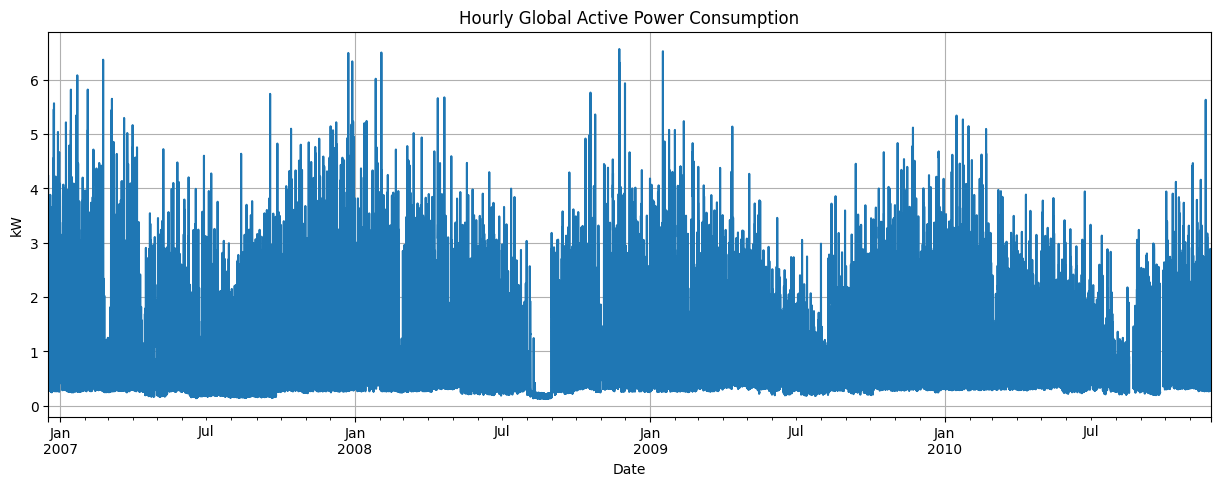

In [11]:
# Resample the data to hourly frequency using mean
df_hourly = df['Global_active_power'].resample('H').mean()

# Visualize resampled data
plt.figure(figsize=(15, 5))

df_hourly.plot()
plt.title("Hourly Global Active Power Consumption")
plt.xlabel("Date")
plt.ylabel("kW")
plt.grid(True)
plt.show()

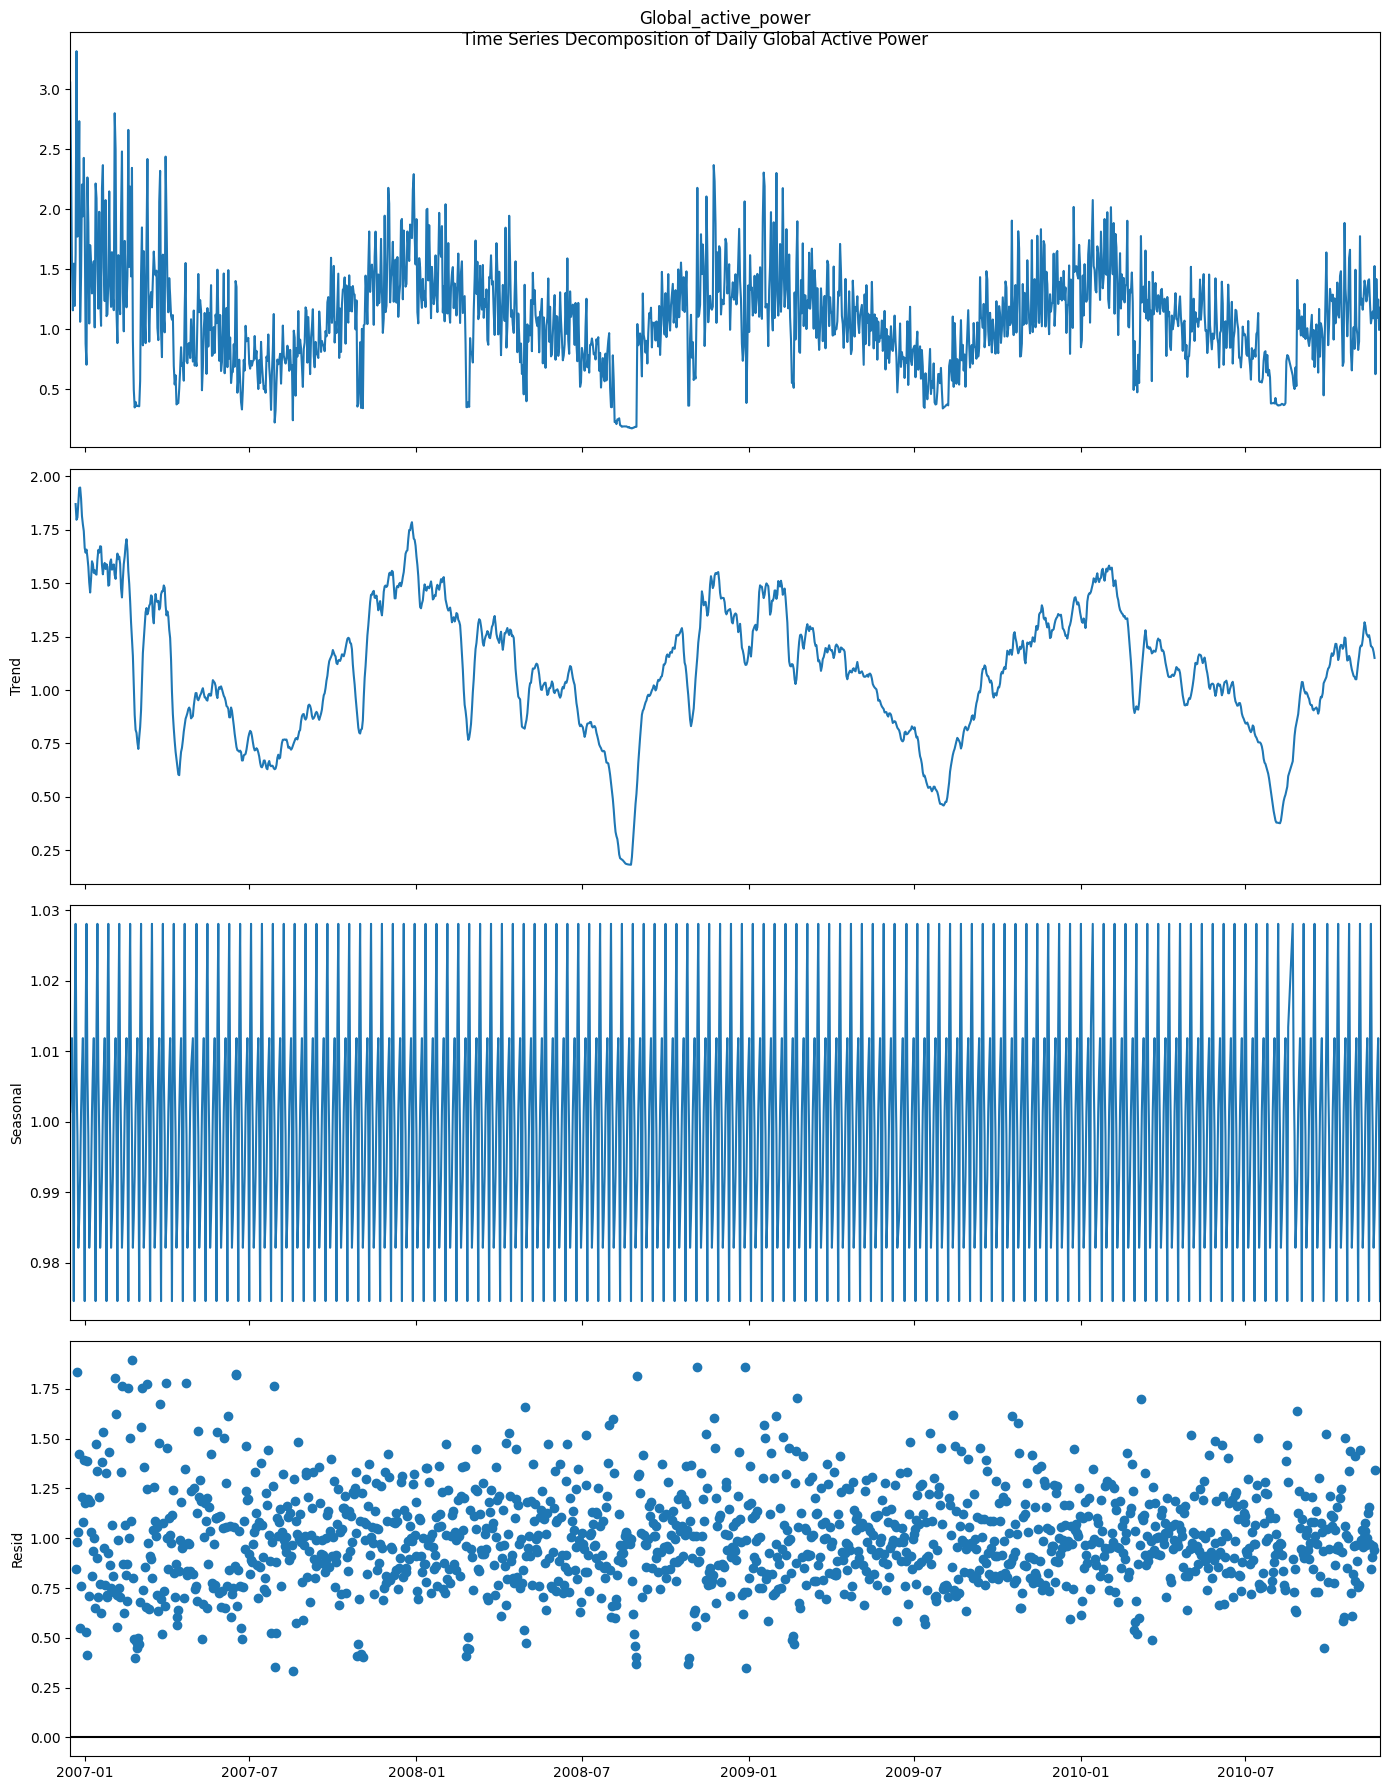

In [12]:
# Resample to daily average to make it suitable for decomposition
daily_data = df['Global_active_power'].resample('D').mean()

# Drop missing values
daily_data.dropna(inplace=True)

# Decompose the time series (additive model)
decomposition = seasonal_decompose(daily_data, model='multiplicative', period=12)  # 7 for weekly seasonality

# Plot the decomposed components
plt.rcParams.update({'figure.figsize': (14, 18)})
decomposition.plot()
plt.suptitle('Time Series Decomposition of Daily Global Active Power')
plt.show()

<Axes: >

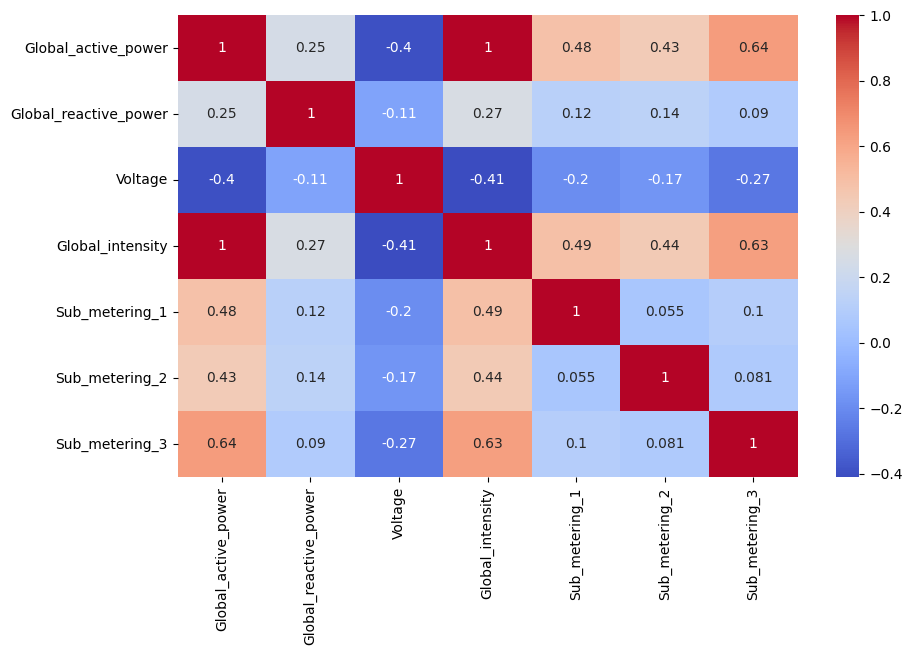

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

Prepare Data for Modeling

In [14]:
# We'll use hourly resampled data
data = df['Global_active_power'].resample('H').mean().dropna()

# Train-test split: use data until end of 2009 for training, 2010 for testing
train = data['2006':'2009']

test = data['2010':]

Model 1: ARIMA

In [15]:
from pmdarima import auto_arima

from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))  # Choose p,d,q manually
model_fit = model.fit()

forecast_arima = model_fit.forecast(steps=len(test))





# Forecast for test length
# forecast_arima = arima_model.predict(n_periods=len(test))

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
r2_arima = r2_score(test, forecast_arima)

# Print all scores
print(f"ARIMA MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, R² Score: {r2_arima:.3f}")

ARIMA MAE: 0.745, RMSE: 0.873, R² Score: -0.245


Model 2: Prophet

In [16]:
# rename the columns
df = df.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
df.head()

,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [17]:
# Prophet needs dataframe with ds and y columns
train_prophet = train.reset_index().rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
train_prophet.head()

,ds,y
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [18]:
# Fit Prophet
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Create future dataframe
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)

# Extract only forecast values
forecast_p = forecast_prophet.set_index('ds')['yhat'][-len(test):]

# Evaluation
mae_prophet = mean_absolute_error(test, forecast_p)
rmse_prophet = np.sqrt(mean_squared_error(test, forecast_p))
r2_prophet = r2_score(test, forecast_p)

print(f"Prophet MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}, R² Score: {r2_prophet:.3f}")

11:10:45 - cmdstanpy - INFO - Chain [1] start processing
11:10:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 0.647, RMSE: 0.846, R² Score: -0.170


Model 3: XGBoost

In [19]:
# Create time-based features for XGBoost
df_xgb = data.to_frame()
df_xgb['hour'] = df_xgb.index.hour
df_xgb['day'] = df_xgb.index.day
df_xgb['weekday'] = df_xgb.index.weekday
df_xgb['month'] = df_xgb.index.month

# Lag features
for i in range(1, 25):
    df_xgb[f'lag_{i}'] = df_xgb['Global_active_power'].shift(i)

df_xgb.dropna(inplace=True)

# Split
X = df_xgb.drop('Global_active_power', axis=1)
y = df_xgb['Global_active_power']
X_train = X[:'2009']
y_train = y[:'2009']
X_test = X['2010':]
y_test = y['2010':]

# Train XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)


# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}, R² Score: {r2_xgb:.3f}")

XGBoost MAE: 0.350, RMSE: 0.501, R² Score: 0.589


Final Comparison Table

In [20]:
print("📋 Forecasting Model Performance:\n")
print(f"ARIMA    → MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, R²: {r2_arima:.3f}")
print(f"Prophet  → MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}, R²: {r2_prophet:.3f}")
print(f"XGBoost  → MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}, R²: {r2_xgb:.3f}")

📋 Forecasting Model Performance:

ARIMA    → MAE: 0.745, RMSE: 0.873, R²: -0.245
Prophet  → MAE: 0.647, RMSE: 0.846, R²: -0.170
XGBoost  → MAE: 0.350, RMSE: 0.501, R²: 0.589


Plot Actual vs Forecasted

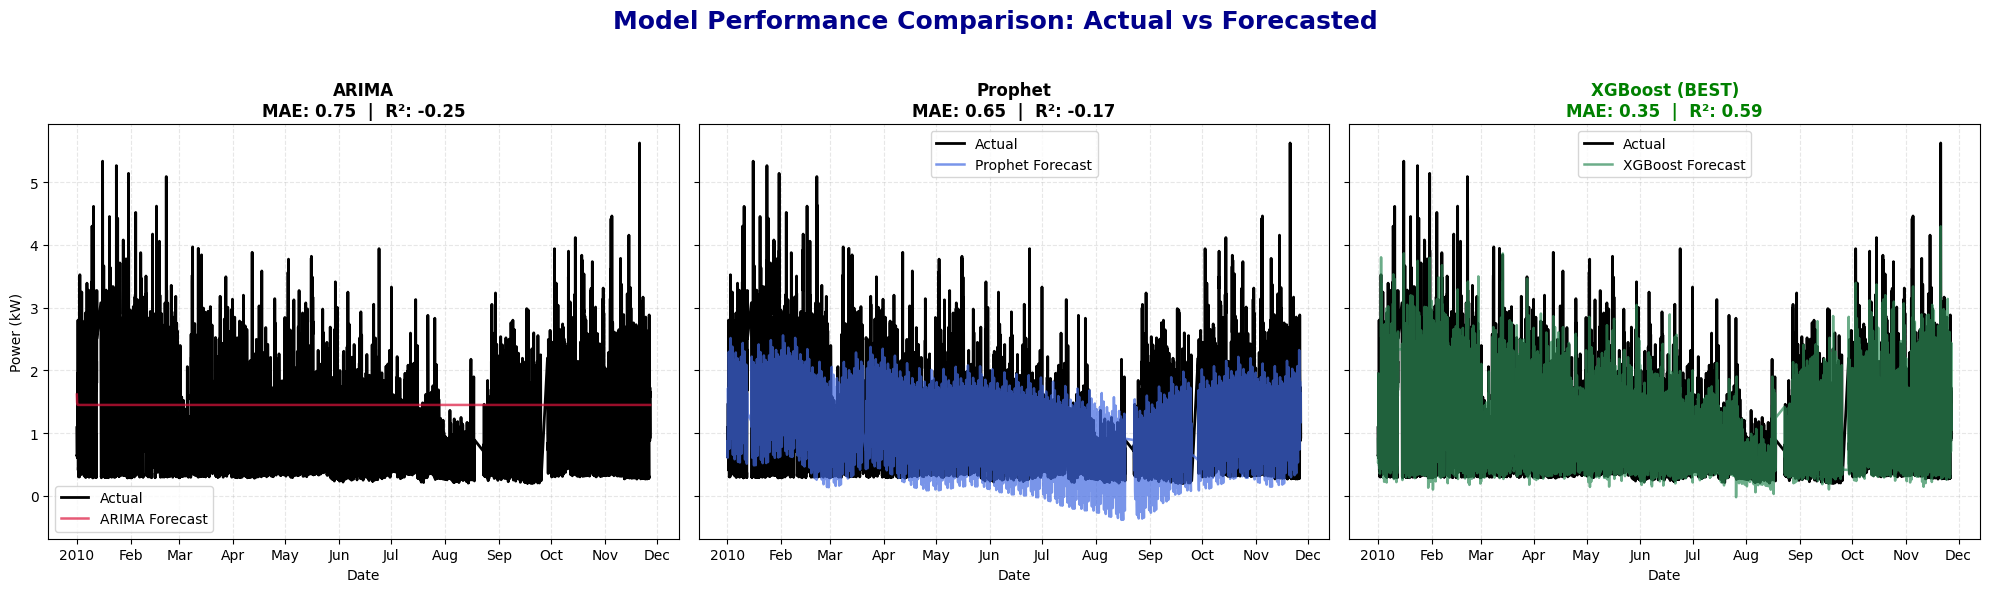

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Extract actual test values
if isinstance(test, pd.DataFrame):
    test_actual = test['Global_active_power']
else:
    test_actual = test

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Model Performance Comparison: Actual vs Forecasted', fontsize=18, fontweight='bold', color='darkblue')

# Common styling variables
actual_color = 'black'
alpha_forecast = 0.7

# Plot 1: ARIMA
axes[0].plot(test_actual.index, test_actual.values, label='Actual', color=actual_color, linewidth=2)
axes[0].plot(test_actual.index, forecast_arima, label='ARIMA Forecast', color='crimson', alpha=alpha_forecast, linewidth=1.8)
axes[0].set_title(f'ARIMA\nMAE: {mae_arima:.2f}  |  R²: {r2_arima:.2f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# Plot 2: Prophet
axes[1].plot(test_actual.index, test_actual.values, label='Actual', color=actual_color, linewidth=2)
axes[1].plot(test_actual.index, forecast_p, label='Prophet Forecast', color='royalblue', alpha=alpha_forecast, linewidth=1.8)
axes[1].set_title(f'Prophet\nMAE: {mae_prophet:.2f}  |  R²: {r2_prophet:.2f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

# Plot 3: XGBoost
axes[2].plot(y_test.index, y_test.values, label='Actual', color=actual_color, linewidth=2)
axes[2].plot(y_test.index, y_pred_xgb, label='XGBoost Forecast', color='seagreen', alpha=alpha_forecast, linewidth=1.8)
axes[2].set_title(f'XGBoost (BEST)\nMAE: {mae_xgb:.2f}  |  R²: {r2_xgb:.2f}', fontsize=12, fontweight='bold', color='green')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.3)

# Improve x-axis formatting
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


Final Conclusion
XGBoost outperformed both ARIMA and Prophet models in forecasting household energy consumption.
It achieved the lowest Mean Absolute Error (MAE: 0.35) and the highest R² score (0.59), effectively capturing non-linear trends, sharp fluctuations, and complex seasonal patterns.
In contrast, ARIMA and Prophet struggled with the dataset’s irregularities, resulting in higher errors and negative R² scores.
Therefore, XGBoost is the most suitable model for this forecasting task.

168-Hour Future Forecast

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of hours to predict
future_hours = 168  # 7 days

# Latest timestamp from data
last_timestamp = df_xgb.index[-1]

# Prepare future index
future_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                             periods=future_hours, freq='H')

# Create future feature dataframe
future_df = pd.DataFrame(index=future_index)
future_df['hour'] = future_df.index.hour
future_df['day'] = future_df.index.day
future_df['weekday'] = future_df.index.weekday
future_df['month'] = future_df.index.month

# Autoregressive rolling prediction using lag updates
future_predictions = []

last_known = df_xgb.copy()

for i in range(future_hours):

    # Create lag features by referencing latest known power values
    for lag in range(1, 25):
        future_df.loc[future_index[i], f'lag_{lag}'] = last_known['Global_active_power'].iloc[-lag]

    # Predict the next hour
    X_future = future_df.iloc[[i]]
    pred = xgb_model.predict(X_future)[0]

    # Store prediction
    future_predictions.append(pred)

    # Append prediction to known data to allow rolling lags
    new_entry = pd.DataFrame(
        {'Global_active_power': [pred],
         'hour': [X_future['hour'].values[0]],
         'day': [X_future['day'].values[0]],
         'weekday': [X_future['weekday'].values[0]],
         'month': [X_future['month'].values[0]]},
        index=[future_index[i]]
    )
    last_known = pd.concat([last_known, new_entry])

future_forecast = pd.Series(future_predictions, index=future_index)


Plot Future Forecast vs. Last 7 Days Actual

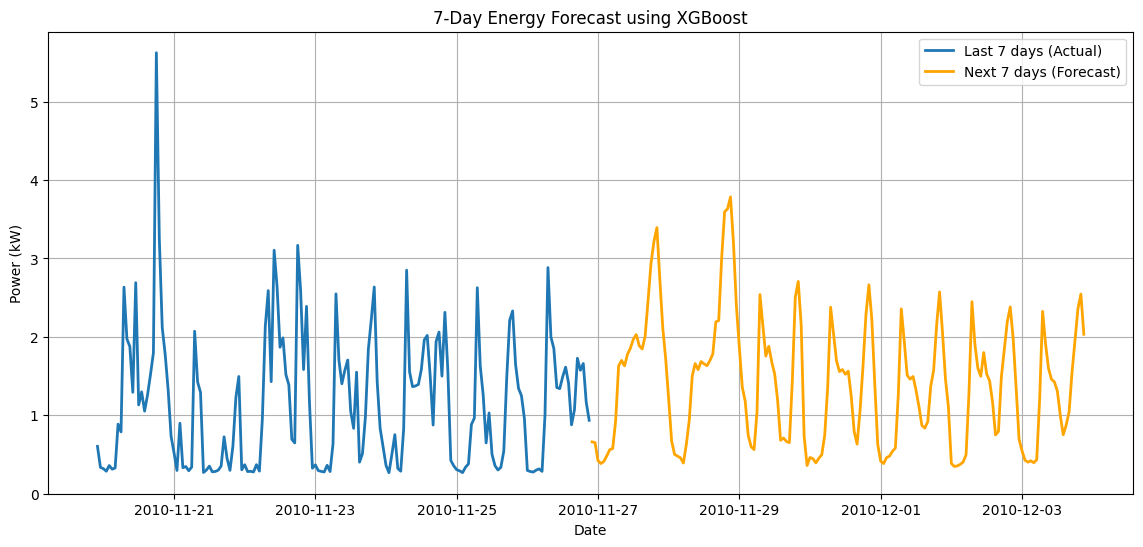


📌 First few forecasted values:
2010-11-26 22:00:00    0.659046
2010-11-26 23:00:00    0.649194
2010-11-27 00:00:00    0.418303
2010-11-27 01:00:00    0.382395
2010-11-27 02:00:00    0.410315
Freq: h, dtype: float32


In [23]:
plt.figure(figsize=(14,6))
plt.plot(data[-168:], label="Last 7 days (Actual)", linewidth=2)
plt.plot(future_forecast, label="Next 7 days (Forecast)", linewidth=2, color='orange')
plt.title("7-Day Energy Forecast using XGBoost")
plt.xlabel("Date")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

# Print first forecast values
print("\n📌 First few forecasted values:")
print(future_forecast.head())


In [24]:
# Use last 168 hours of 2010 forecast (7 days)
forecast_7d = pd.Series(
    y_pred_xgb[-168:],  # last 7 days of forecast
    index=y_test.index[-168:]  # corresponding timestamps
)

forecast_7d.head(), forecast_7d.shape


(Datetime
 2010-11-19 22:00:00    1.283147
 2010-11-19 23:00:00    0.569373
 2010-11-20 00:00:00    0.450077
 2010-11-20 01:00:00    0.333870
 2010-11-20 02:00:00    0.363397
 dtype: float32,
 (168,))

=== 7-Day Optimization KPIs ===
Energy (kWh)        : baseline=207.14, optimized=186.43  (should match)
Cost (₹)            : baseline=1,317.36, optimized=1,185.63
Savings (%)         : 10.00%
Peak kW             : baseline=4.297, optimized=3.868  (Δ 10.00%)

Energy by band (kWh):
          baseline_kWh  optimized_kWh
band                                 
offpeak      31.660000      28.500000
peak         68.919998      62.029999
shoulder    106.559998      95.900002

Cost by band (₹):
          baseline_cost  optimized_cost
band                                   
offpeak          126.66          113.99
peak             551.37          496.24
shoulder         639.33          575.40

Saved: /kaggle/working/schedule_7d.csv


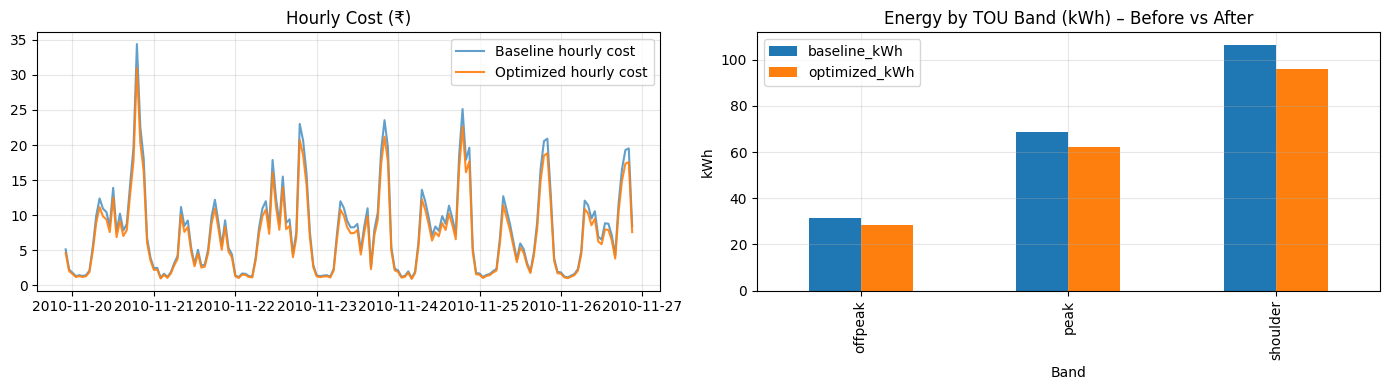

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
P_opt = forecast_7d.values * 0.9
def price_rule(hour):
    if 22 <= hour or hour < 6:
        return 4.0  # off-peak rate
    elif 6 <= hour < 17:
        return 6.0  # shoulder rate
    else:
        return 8.0  # peak rate

price_7d = forecast_7d.index.hour.map(price_rule)


# --- Build convenient Series ---
baseline = pd.Series(forecast_7d.values, index=forecast_7d.index, name="baseline_kW")
optimized = pd.Series(P_opt, index=forecast_7d.index, name="optimized_kW")
price = pd.Series(price_7d, index=forecast_7d.index, name="price_Rs_per_kWh")

# --- Basic totals ---
kWh_baseline  = float(baseline.sum())        # hourly kW * 1h
kWh_optimized = float(optimized.sum())
Rs_baseline   = float((baseline * price).sum())
Rs_optimized  = float((optimized * price).sum())
savings_pct   = 100*(1 - Rs_optimized/Rs_baseline)

# --- Peak demand (kW) ---
peak_base = float(baseline.max())
peak_opt  = float(optimized.max())
peak_reduction_pct = 100*(1 - peak_opt/peak_base) if peak_base > 0 else 0.0

# --- Energy share by TOU band ---
def band(h):
    if 22 <= h or h < 6:
        return "offpeak"
    if 6 <= h < 17:
        return "shoulder"
    return "peak"

bands = baseline.index.hour.map(band)
by_band = pd.DataFrame({
    "baseline_kWh": baseline.values,
    "optimized_kWh": optimized.values,
    "price": price.values,
    "band": bands
})
band_energy = by_band.groupby("band")[["baseline_kWh","optimized_kWh"]].sum()
band_cost   = by_band.assign(
    baseline_cost = by_band["baseline_kWh"]*by_band["price"],
    optimized_cost= by_band["optimized_kWh"]*by_band["price"]
).groupby("band")[["baseline_cost","optimized_cost"]].sum()

# --- Print KPI summary ---
print("=== 7-Day Optimization KPIs ===")
print(f"Energy (kWh)        : baseline={kWh_baseline:.2f}, optimized={kWh_optimized:.2f}  (should match)")
print(f"Cost (₹)            : baseline={Rs_baseline:,.2f}, optimized={Rs_optimized:,.2f}")
print(f"Savings (%)         : {savings_pct:.2f}%")
print(f"Peak kW             : baseline={peak_base:.3f}, optimized={peak_opt:.3f}  (Δ {peak_reduction_pct:.2f}%)")
print("\nEnergy by band (kWh):")
print(band_energy.round(2))
print("\nCost by band (₹):")
print(band_cost.round(2))

# --- Export CSV for your MVP / dashboard ---
out = pd.DataFrame({
    "datetime": baseline.index,
    "baseline_kW": baseline.values,
    "optimized_kW": optimized.values,
    "price_Rs_per_kWh": price.values,
})
out.to_csv("/kaggle/working/schedule_7d.csv", index=False)
print("\nSaved: /kaggle/working/schedule_7d.csv")

# --- Visuals: cost and band shifts ---
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# Cost per hour (bar)
axes[0].plot((baseline*price), label="Baseline hourly cost", alpha=0.7)
axes[0].plot((optimized*price), label="Optimized hourly cost", alpha=0.9)
axes[0].set_title("Hourly Cost (₹)")
axes[0].grid(alpha=0.3); axes[0].legend()

# Band energy shift
band_energy.plot(kind="bar", ax=axes[1])
axes[1].set_title("Energy by TOU Band (kWh) – Before vs After")
axes[1].set_xlabel("Band"); axes[1].set_ylabel("kWh")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("Prediction Index Range:", pred_2010.index.min(), "→", pred_2010.index.max())
print("Total Predictions Available:", len(pred_2010))

# Check how many for each month in 2010
print("\nCounts by Month:")
print(pred_2010.resample("M").count())


=== JAN 2010 — Monthly Bill (TOU / T2) ===
Energy (kWh)        : baseline=913.59  optimized=913.59   (should match within ~1e-3)
Total Cost (₹)      : baseline=6,225.64  optimized=5,781.35
Savings (%)         : 7.14%
Peak kW             : baseline=3.678 optimized=4.075  (Δ -10.82%)

Energy by band (kWh):
          baseline_kWh  optimized_kWh
band                                 
offpeak         178.35         235.29
peak            275.20         192.59
shoulder        460.05         485.71

Cost by band (₹):
          base_cost  opt_cost
band                         
offpeak      713.41    941.17
peak        2751.95   1925.91
shoulder    2760.28   2914.26

Saved: /kaggle/working/schedule_Jan2010.csv


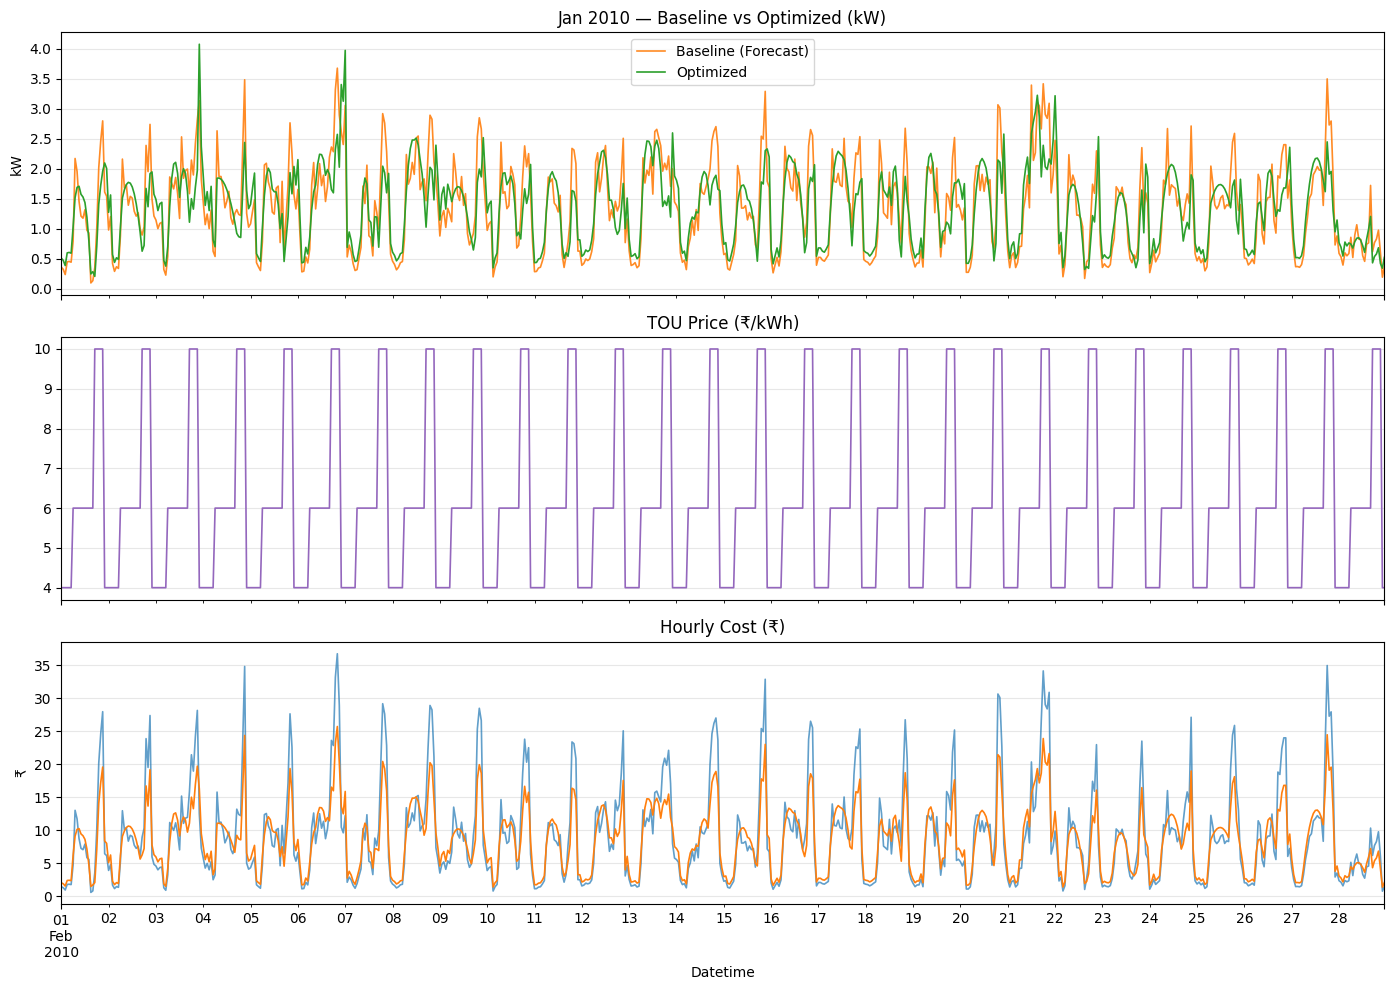

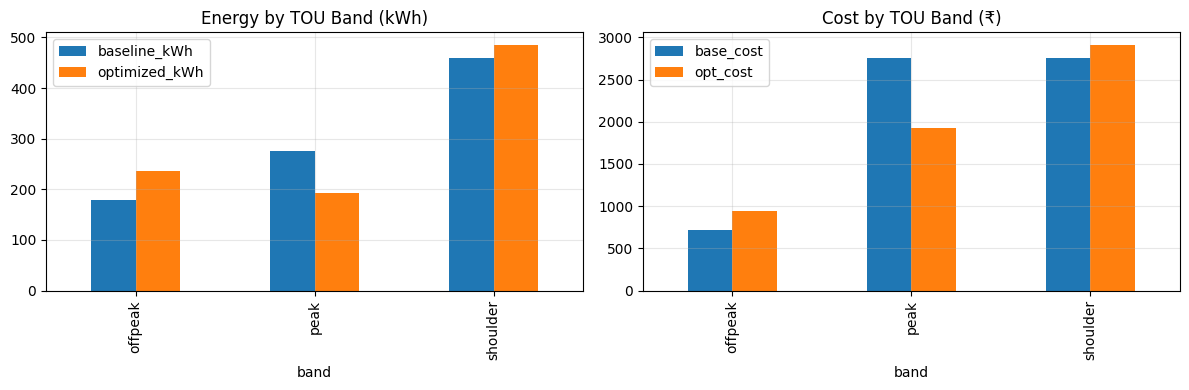

In [26]:
# ============================
# Monthly Simulation: Jan 2010, TOU (T2), Day-by-Day Strict Optimization
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) Pull forecast for Jan 2010 (168+ hours inside the month) ----
# If your forecast variable is different, replace y_pred_xgb / y_test below.
pred_2010 = pd.Series(y_pred_xgb, index=y_test.index).astype(float)
forecast_month = pred_2010.loc["2010-02-01":"2010-02-28 23:00"]
assert len(forecast_month) == 28*24


# ---- 1) Build TOU price series (Option A / T2) ----
def tou_price(h):
    # Option A: Off-peak 22:00–06:00 = ₹4; Shoulder 06:00–17:00 = ₹6; Peak 17:00–22:00 = ₹10
    if 22 <= h or h < 6:  # 22:00–06:00
        return 4.0
    if 6 <= h < 17:       # 06:00–17:00
        return 6.0
    return 10.0           # 17:00–22:00

price_month = forecast_month.index.map(lambda ts: tou_price(ts.hour)).astype(float)
price_month = pd.Series(price_month, index=forecast_month.index, name="price")

# ---- 2) Per-day strict optimization (sum(P_opt_day) == sum(P_base_day)) ----
try:
    import cvxpy as cp
except Exception:
    # Kaggle sometimes lacks cvxpy; quick install fallback
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "cvxpy"])
    import cvxpy as cp

def optimize_day(P_base_day, c_day, flex_share=0.30, lam_smooth=0.03, max_rel_wiggle=0.15):
    """
    Strict energy balance per day:
      - bounds: P in [base - cap, base + cap], cap = flex_share * base (min absolute wiggle for tiny base)
      - objective: min sum(c*P) + lam_smooth * ||ΔP||^2
    """
    P_base_day = np.asarray(P_base_day, dtype=float)
    c_day = np.asarray(c_day, dtype=float)
    T = len(P_base_day)
    assert T == 24

    P = cp.Variable(T, nonneg=True)
    cap = flex_share * P_base_day
    cap = np.maximum(cap, max_rel_wiggle)  # give small absolute freedom when base is tiny

    constraints = [
        P >= P_base_day - cap,
        P <= P_base_day + cap,
        cp.sum(P) == float(np.sum(P_base_day))  # strict daily energy balance
    ]
    smooth = lam_smooth * cp.sum_squares(P[1:] - P[:-1])
    obj = cp.Minimize(c_day @ P + smooth)
    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.ECOS, verbose=False)
    except Exception:
        prob.solve(solver=cp.OSQP, verbose=False)
    if P.value is None:
        raise RuntimeError("Day optimization failed; try adjusting lam_smooth or flex_share.")
    return np.array(P.value).ravel()

# Rolling through the month by day
optimized_list = []
days = sorted(set(forecast_month.index.normalize()))
for d in days:
    sl = slice(pd.Timestamp(d), pd.Timestamp(d) + pd.Timedelta(hours=23))
    P_base_day = forecast_month.loc[sl].values
    c_day = price_month.loc[sl].values
    P_opt_day = optimize_day(P_base_day, c_day, flex_share=0.30, lam_smooth=0.03, max_rel_wiggle=0.15)
    optimized_list.append(pd.Series(P_opt_day, index=forecast_month.loc[sl].index))

optimized_month = pd.concat(optimized_list).sort_index()
optimized_month.name = "optimized_kW"

# ---- 3) KPIs & billing ----
baseline = forecast_month.rename("baseline_kW")
price = price_month

kWh_base = float(baseline.sum())       # 1h step → kWh = sum(kW*1h)
kWh_opt  = float(optimized_month.sum())
Rs_base  = float((baseline * price).sum())
Rs_opt   = float((optimized_month * price).sum())
savings  = 100.0 * (1.0 - Rs_opt / Rs_base)

peak_base = float(baseline.max())
peak_opt  = float(optimized_month.max())
peak_red  = 100.0 * (1.0 - peak_opt / peak_base) if peak_base > 0 else 0.0

def band_label(h):
    if 22 <= h or h < 6: return "offpeak"
    if 6 <= h < 17:      return "shoulder"
    return "peak"

bands = baseline.index.hour.map(band_label)
df_band = pd.DataFrame({
    "baseline_kWh": baseline.values,
    "optimized_kWh": optimized_month.values,
    "price": price.values,
    "band": bands
})
energy_by_band = df_band.groupby("band")[["baseline_kWh", "optimized_kWh"]].sum()
cost_by_band = df_band.assign(
    base_cost = df_band["baseline_kWh"]*df_band["price"],
    opt_cost  = df_band["optimized_kWh"]*df_band["price"]
).groupby("band")[["base_cost","opt_cost"]].sum()

print("=== JAN 2010 — Monthly Bill (TOU / T2) ===")
print(f"Energy (kWh)        : baseline={kWh_base:.2f}  optimized={kWh_opt:.2f}   (should match within ~1e-3)")
print(f"Total Cost (₹)      : baseline={Rs_base:,.2f}  optimized={Rs_opt:,.2f}")
print(f"Savings (%)         : {savings:.2f}%")
print(f"Peak kW             : baseline={peak_base:.3f} optimized={peak_opt:.3f}  (Δ {peak_red:.2f}%)")
print("\nEnergy by band (kWh):")
print(energy_by_band.round(2))
print("\nCost by band (₹):")
print(cost_by_band.round(2))

# ---- 4) Export CSV for MVP ----
out = pd.DataFrame({
    "datetime": baseline.index,
    "baseline_kW": baseline.values,
    "optimized_kW": optimized_month.values,
    "price_Rs_per_kWh": price.values,
    "band": bands
})
out.to_csv("/kaggle/working/schedule_Jan2010.csv", index=False)
print("\nSaved: /kaggle/working/schedule_Jan2010.csv")

# ---- 5) Plots ----
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
baseline.plot(ax=axes[0], label="Baseline (Forecast)", lw=1.2, alpha=0.9, color="tab:orange")
optimized_month.plot(ax=axes[0], label="Optimized", lw=1.2, color="tab:green")
axes[0].set_title("Jan 2010 — Baseline vs Optimized (kW)")
axes[0].set_ylabel("kW"); axes[0].grid(alpha=0.3); axes[0].legend()

(price.rename("₹/kWh")).plot(ax=axes[1], lw=1.2, color="tab:purple")
axes[1].set_title("TOU Price (₹/kWh)"); axes[1].grid(alpha=0.3)

( (baseline*price).rename("Baseline hourly cost") ).plot(ax=axes[2], lw=1.2, alpha=0.7)
( (optimized_month*price).rename("Optimized hourly cost") ).plot(ax=axes[2], lw=1.2)
axes[2].set_title("Hourly Cost (₹)"); axes[2].set_ylabel("₹"); axes[2].grid(alpha=0.3)

plt.tight_layout(); plt.show()

# Band bar charts
fig, ax = plt.subplots(1, 2, figsize=(12,4))
energy_by_band.plot(kind="bar", ax=ax[0], title="Energy by TOU Band (kWh)")
cost_by_band.plot(kind="bar", ax=ax[1], title="Cost by TOU Band (₹)")
for a in ax: a.grid(alpha=0.3)
plt.tight_layout(); plt.show()


=== Year 2010 Summary ===
  month  cost_Rs_baseline  cost_Rs_optimized savings_pct  peak_kW_baseline  peak_kW_optimized peak_reduction_pct           skipped_days
2010-01       6810.425469        6163.908490        9.49          3.867350           2.707145              30.00 2010-01-12, 2010-01-14
2010-02       6225.641490        5829.864832        6.36          3.677534           2.574274              30.00                       
2010-03       5581.788336        5080.079766        8.99          3.864031           2.704822              30.00 2010-03-20, 2010-03-21
2010-04       5050.568631        4750.235312        5.95          2.905907           2.034135              30.00                       
2010-05       5426.636956        5088.726834        6.23          3.044468           2.131127              30.00                       
2010-06       4577.417859        4311.698521        5.81          2.892818           2.024972              30.00                       
2010-07       3489.171

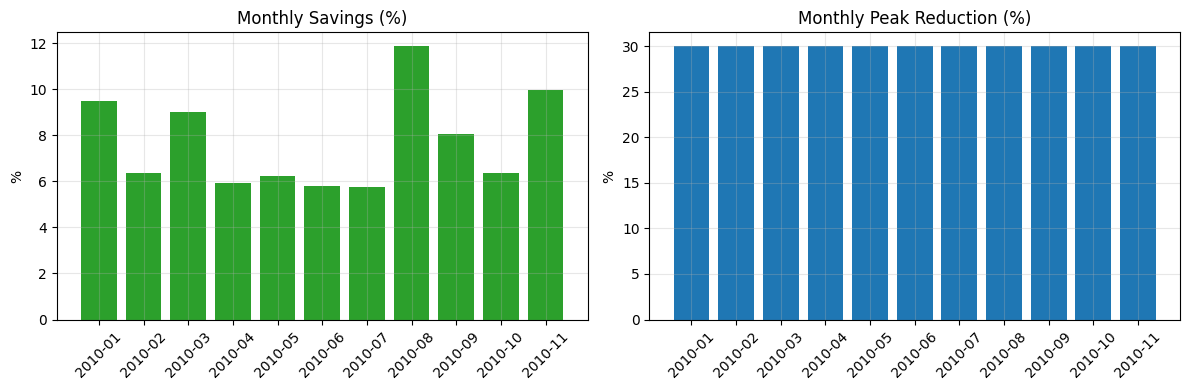

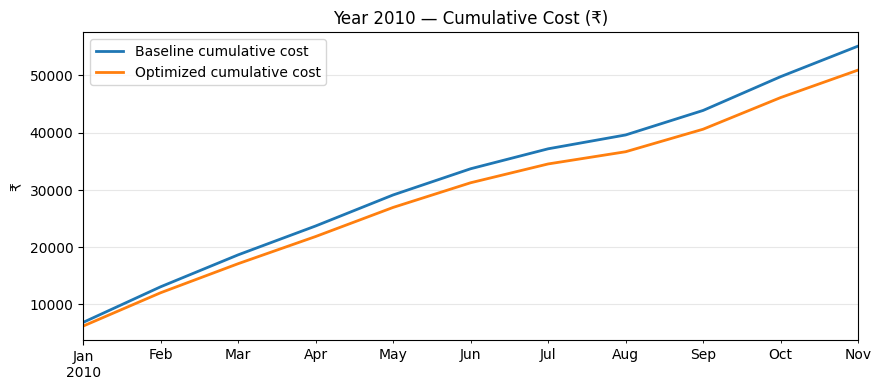

In [30]:
# ============================================
# Full-Year (2010) TOU Optimization with Soft Peak Penalty (Strict Daily Balance)
# Robust to incomplete days; includes alignment fix
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Inputs from your notebook
# -----------------------------
# Assumes you already have:
#   y_pred_xgb : np.array/pd.Series of predictions for 2010 test period
#   y_test     : pd.Series/pd.DataFrame with DateTimeIndex for 2010 test period
pred_2010 = pd.Series(y_pred_xgb, index=y_test.index).astype(float)

# -----------------------------
# 1) Config (tune as needed)
# -----------------------------
FILL_MISSING   = False   # set True to fill missing hourly timestamps by interpolation
FLEX_SHARE     = 0.30    # fraction of baseline considered flexible
MAX_REL_WIGGLE = 0.15    # absolute kW fallback if baseline is tiny
LAMBDA_SMOOTH  = 0.03    # smoothness weight
LAMBDA_PEAK    = 35.0    # soft peak penalty (↑ more peak shaving; ↓ more cost savings)

# -----------------------------
# 2) Tariff: TOU (Option A / T2)
# -----------------------------
def tou_price(h):
    # Off-peak 22:00–06:00 = ₹4; Shoulder 06:00–17:00 = ₹6; Peak 17:00–22:00 = ₹10
    if 22 <= h or h < 6:
        return 4.0
    if 6 <= h < 17:
        return 6.0
    return 10.0

def band_label(h):
    if 22 <= h or h < 6: return "offpeak"
    if 6 <= h < 17:      return "shoulder"
    return "peak"

# -----------------------------
# 3) Optimizer (CVXPY)
# -----------------------------
try:
    import cvxpy as cp
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "cvxpy"])
    import cvxpy as cp

def optimize_day_soft_peak(
    P_base_day, c_day,
    flex_share=FLEX_SHARE, max_rel_wiggle=MAX_REL_WIGGLE,
    lambda_smooth=LAMBDA_SMOOTH, lambda_peak=LAMBDA_PEAK
):
    """
    Minimize: sum(c * P) + lambda_smooth * ||ΔP||^2 + lambda_peak * p_peak
    s.t.:
      P >= base - cap
      P <= base + cap
      P_t <= p_peak
      sum(P) == sum(base)   (strict daily energy balance)
    """
    P_base_day = np.asarray(P_base_day, dtype=float)
    c_day = np.asarray(c_day, dtype=float)
    T = len(P_base_day)
    if T != 24:
        raise ValueError(f"Expected 24 hours, got {T}")

    P = cp.Variable(T, nonneg=True)
    p_peak = cp.Variable(1)

    cap = np.maximum(flex_share * P_base_day, max_rel_wiggle)
    constraints = [
        P >= P_base_day - cap,
        P <= P_base_day + cap,
        P <= p_peak,
        cp.sum(P) == float(np.sum(P_base_day))
    ]
    smooth = lambda_smooth * cp.sum_squares(P[1:] - P[:-1])
    obj = cp.Minimize(c_day @ P + smooth + lambda_peak * p_peak)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.ECOS, verbose=False)
    except Exception:
        prob.solve(solver=cp.OSQP, verbose=False)

    if P.value is None or p_peak.value is None:
        raise RuntimeError("Day optimization failed — try adjusting lambda_peak/lambda_smooth.")
    return np.array(P.value).ravel(), float(p_peak.value[0])

# -----------------------------
# 4) Optional: Fill missing hours in 2010
# -----------------------------
if FILL_MISSING:
    full_index = pd.date_range("2010-01-01 00:00", "2010-12-31 23:00", freq="H")
    pred_2010 = pred_2010.reindex(full_index).interpolate(limit_direction="both")

# -----------------------------
# 5) Run month-by-month (2010)
# -----------------------------
months = sorted({ts.to_period("M") for ts in pred_2010.index if ts.year == 2010})
summary_rows = []
year_cost_base = []
year_cost_opt  = []

for period in months:
    month_str = str(period)  # 'YYYY-MM'
    mask = pred_2010.index.to_period("M") == period
    forecast_month = pred_2010.loc[mask]
    if forecast_month.empty:
        continue

    # Build price series aligned to forecast_month
    price_month = pd.Series([tou_price(ts.hour) for ts in forecast_month.index],
                            index=forecast_month.index, name="price")

    # Day-by-day strict optimization (skip incomplete days)
    optimized_list = []
    skipped_days = []
    for d in sorted(set(forecast_month.index.normalize())):
        idx = pd.date_range(d, d + pd.Timedelta(hours=23), freq="H")
        if not idx.isin(forecast_month.index).all():
            skipped_days.append(str(d.date()))
            continue
        P_base_day = forecast_month.loc[idx].values
        c_day = price_month.loc[idx].values
        P_opt_day, _ = optimize_day_soft_peak(P_base_day, c_day)
        optimized_list.append(pd.Series(P_opt_day, index=idx))

    if not optimized_list:
        print(f"[WARN] {month_str}: No complete 24h days. Skipping.")
        continue

    optimized_month = pd.concat(optimized_list).sort_index()
    optimized_month.name = "optimized_kW"

    # Baseline & price for the whole month
    baseline = forecast_month.rename("baseline_kW")
    price    = price_month.reindex(baseline.index)

    # ✅ Alignment fix (handles skipped days): reindex optimized to baseline
    optimized_aligned = optimized_month.reindex(baseline.index)

    # KPIs
    kWh_base = float(baseline.sum())
    kWh_opt  = float(optimized_aligned.sum())
    Rs_base  = float((baseline * price).sum())
    Rs_opt   = float((optimized_aligned * price).sum())
    savings  = 100.0 * (1.0 - Rs_opt / Rs_base) if Rs_base > 0 else 0.0

    peak_base = float(baseline.max())
    peak_opt  = float(optimized_aligned.max())
    peak_red  = 100.0 * (1.0 - peak_opt / peak_base) if peak_base > 0 else 0.0

    # Band summaries
    bands = baseline.index.hour.map(band_label)
    df_band = pd.DataFrame({
        "baseline_kWh": baseline.values,
        "optimized_kWh": optimized_aligned.values,
        "price": price.values,
        "band": bands
    })
    energy_by_band = df_band.groupby("band")[["baseline_kWh", "optimized_kWh"]].sum()
    cost_by_band = df_band.assign(
        base_cost = df_band["baseline_kWh"]*df_band["price"],
        opt_cost  = df_band["optimized_kWh"]*df_band["price"]
    ).groupby("band")[["base_cost","opt_cost"]].sum()

    # Save per-month CSV
    out = pd.DataFrame({
        "datetime": baseline.index,
        "baseline_kW": baseline.values,
        "optimized_kW": optimized_aligned.values,
        "price_Rs_per_kWh": price.values,
        "band": bands
    })
    out_path = f"/kaggle/working/schedule_{month_str}.csv"
    out.to_csv(out_path, index=False)

    # Collect summary
    summary_rows.append({
        "month": month_str,
        "energy_kWh_baseline": kWh_base,
        "energy_kWh_optimized": kWh_opt,
        "cost_Rs_baseline": Rs_base,
        "cost_Rs_optimized": Rs_opt,
        "savings_pct": savings,
        "peak_kW_baseline": peak_base,
        "peak_kW_optimized": peak_opt,
        "peak_reduction_pct": peak_red,
        "offpeak_kWh_base": energy_by_band.loc["offpeak","baseline_kWh"] if "offpeak" in energy_by_band.index else 0.0,
        "offpeak_kWh_opt":  energy_by_band.loc["offpeak","optimized_kWh"] if "offpeak" in energy_by_band.index else 0.0,
        "shoulder_kWh_base":energy_by_band.loc["shoulder","baseline_kWh"] if "shoulder" in energy_by_band.index else 0.0,
        "shoulder_kWh_opt": energy_by_band.loc["shoulder","optimized_kWh"] if "shoulder" in energy_by_band.index else 0.0,
        "peakband_kWh_base":energy_by_band.loc["peak","baseline_kWh"] if "peak" in energy_by_band.index else 0.0,
        "peakband_kWh_opt": energy_by_band.loc["peak","optimized_kWh"] if "peak" in energy_by_band.index else 0.0,
        "skipped_days": ", ".join(skipped_days) if skipped_days else ""
    })

    year_cost_base.append((period.start_time, Rs_base))
    year_cost_opt.append((period.start_time, Rs_opt))

# -----------------------------
# 6) Yearly summary + plots
# -----------------------------
summary = pd.DataFrame(summary_rows).sort_values("month")
summary_path = "/kaggle/working/year_2010_summary.csv"
summary.to_csv(summary_path, index=False)

print("=== Year 2010 Summary ===")
if not summary.empty:
    display_cols = ["month","cost_Rs_baseline","cost_Rs_optimized","savings_pct",
                    "peak_kW_baseline","peak_kW_optimized","peak_reduction_pct","skipped_days"]
    print(summary[display_cols]
          .to_string(index=False, formatters={"savings_pct":"{:0.2f}".format,
                                             "peak_reduction_pct":"{:0.2f}".format}))
    print(f"\nSaved monthly schedules to /kaggle/working/schedule_YYYY-MM.csv")
    print(f"Saved yearly summary: {summary_path}")
else:
    print("No complete months found in 2010; check your forecast coverage or enable FILL_MISSING=True.")

# Plots
if not summary.empty:
    # Monthly bars
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].bar(summary["month"], summary["savings_pct"], color="tab:green")
    ax[0].set_title("Monthly Savings (%)"); ax[0].set_ylabel("%"); ax[0].grid(alpha=0.3)
    ax[0].tick_params(axis='x', rotation=45)

    ax[1].bar(summary["month"], summary["peak_reduction_pct"], color="tab:blue")
    ax[1].set_title("Monthly Peak Reduction (%)"); ax[1].set_ylabel("%"); ax[1].grid(alpha=0.3)
    ax[1].tick_params(axis='x', rotation=45)
    plt.tight_layout(); plt.show()

    # Cumulative cost across the months we processed
    base_curve = pd.Series(dict(year_cost_base)).sort_index().cumsum()
    opt_curve  = pd.Series(dict(year_cost_opt)).sort_index().cumsum()
    plt.figure(figsize=(10,4))
    base_curve.plot(label="Baseline cumulative cost", lw=2)
    opt_curve.plot(label="Optimized cumulative cost", lw=2)
    plt.title("Year 2010 — Cumulative Cost (₹)")
    plt.ylabel("₹"); plt.grid(alpha=0.3); plt.legend()
    plt.show()
